# Multiclass Logistic Regression

This is an example of multiclass logistic regression used to classify handwritten digits.

In [1]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from mltools.generic import OVRClassifier
from mltools.glm import LogisticRegression
from mltools.optimization import NewtonRaphson
from mltools.preprocessing import PCA
from mltools.visualization import pca_label_plot

## Loading the data

We use the [UCI ML handwritten digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), imported from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).
This dataset contains 1797 8x8 samples of handwritten digits.
After shuffling the data, we split it 50/50 into training and testing datasets.

In [2]:
data = load_digits()
x = data.data
y = data.target

np.random.seed(100)
idx = np.random.permutation(y.size)
x_train, x_test = np.array_split(x[idx], 2)
y_train, y_test = np.array_split(y[idx], 2)

## Visualizing the training data

By reducing the training data to 2 dimensions using PCA, we can display a scatter plot of the training features and their labels.

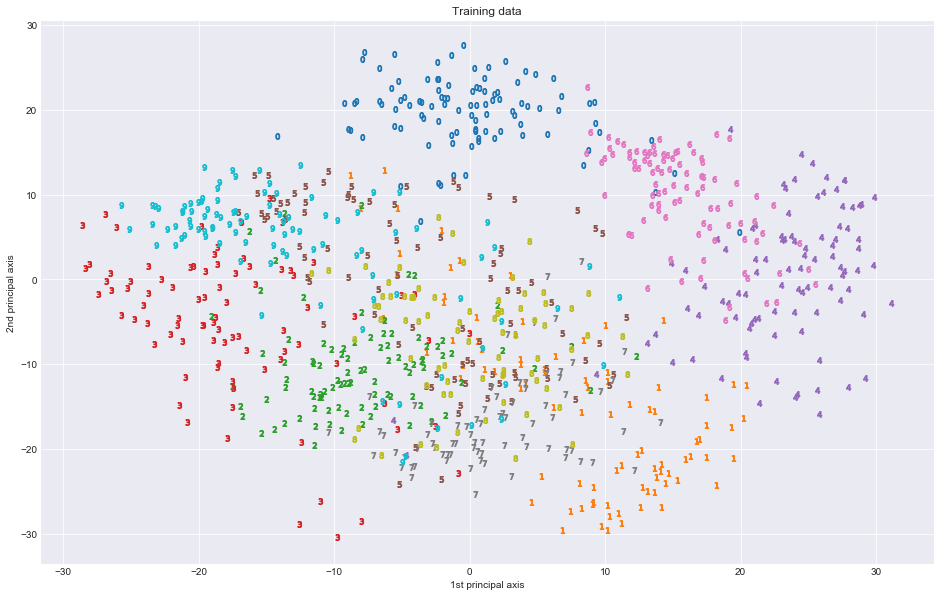

In [3]:
pca = PCA()
pca.fit(x_train)
x_train_2d = pca.transform(x_train, dim=2)

plt.figure(figsize=(16, 10))
sns.set_style("darkgrid")
for label in data.target_names:
    marker = "$" + str(label) + "$"
    idx = y_train == label
    plt.scatter(x_train_2d[idx, 0], x_train_2d[idx, 1], marker=marker)
plt.title("Training data")
plt.xlabel("1st principal axis")
plt.ylabel("2nd principal axis")
plt.show()
plt.close()

## The multiclass logistic regression model

To make digit predictions, we initialize an `OVRCLassifier` based on the `LogisticRegression` class and fit it using the training data.

In [4]:
%%time
clf = OVRClassifier(base=LogisticRegression, penalty="l2", lam=0.01)
clf.fit(x=x_train, y=y_train, optimizer=NewtonRaphson(iterations=100))

CPU times: user 10.1 s, sys: 870 ms, total: 11 s
Wall time: 3.77 s


Next, we report this model's accuracy on the training and testing data.

In [5]:
pred_train = clf.predict(x_train)
pred_test = clf.predict(x_test)
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f"Training accuracy: {accuracy_train:.4f}")
print(f"Testing accuracy:  {accuracy_test:.4f}")

Training accuracy: 0.9911
Testing accuracy:  0.9621


## Visualizing the confusion matrix

To see how the multiclass logistic regression classifier misclassifies particular digits as other particular digits, we can plot the confusion matrices of the training and testing predictions.
For a good model, most off-diagonal entries will be close to zero.

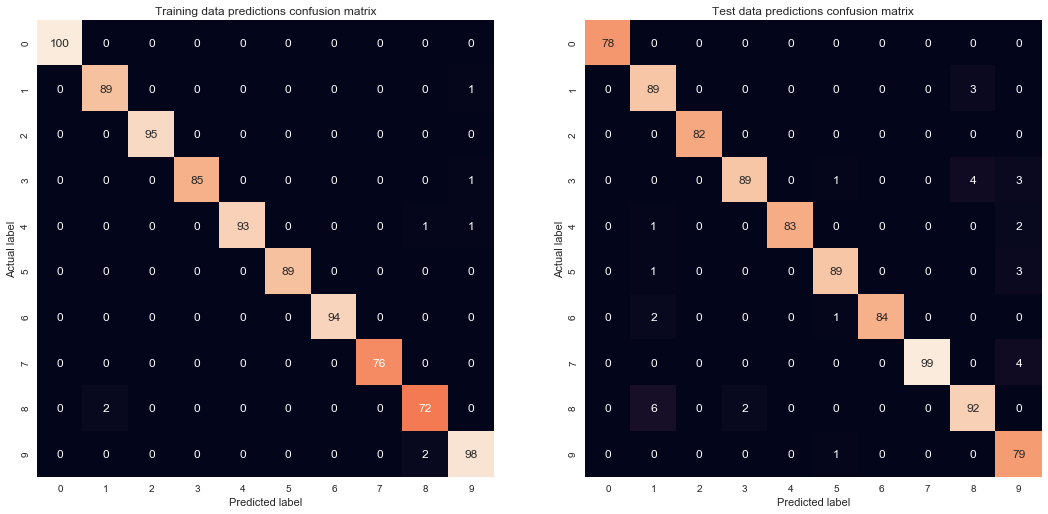

In [6]:
sns.set()
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
sns.heatmap(confusion_matrix(y_train, pred_train), annot=True, ax=axes[0], square=True, cbar=False, fmt="d")
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, ax=axes[1], square=True, cbar=False, fmt="d")
axes[0].set_title("Training data predictions confusion matrix")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("Actual label")
axes[1].set_title("Test data predictions confusion matrix")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("Actual label")
plt.show()
plt.close()

## Plotting the predictions

By reducing the testing data to 2 dimensions using PCA, we can display a scatter plot of the test data points and the corresponding predictions.

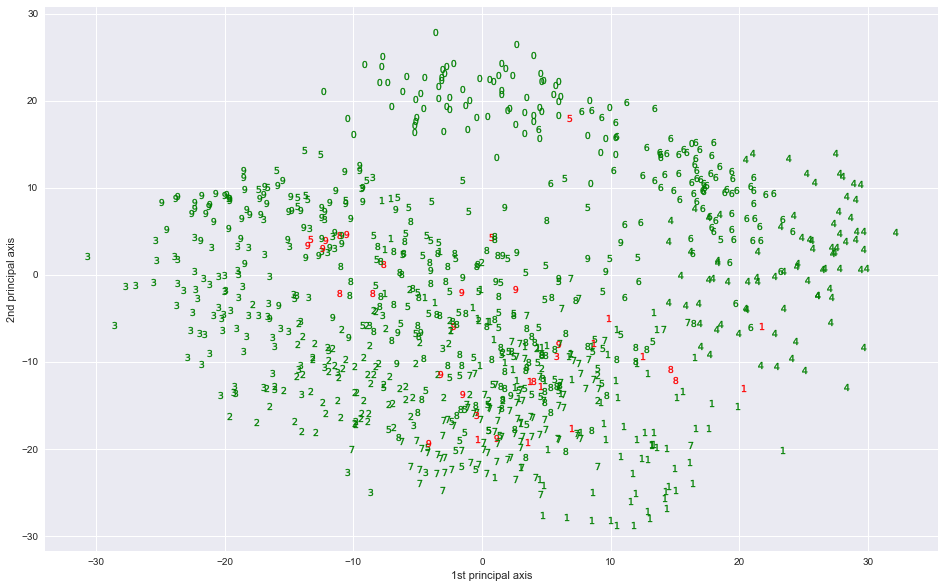

In [7]:
plt.figure(figsize=(16, 10))
pca_label_plot(x_test, y_test, pred_test, pca=pca)
plt.show()
plt.close()

## What was misclassified?

Let's see some of the digits in the test set that were classified incorrectly.

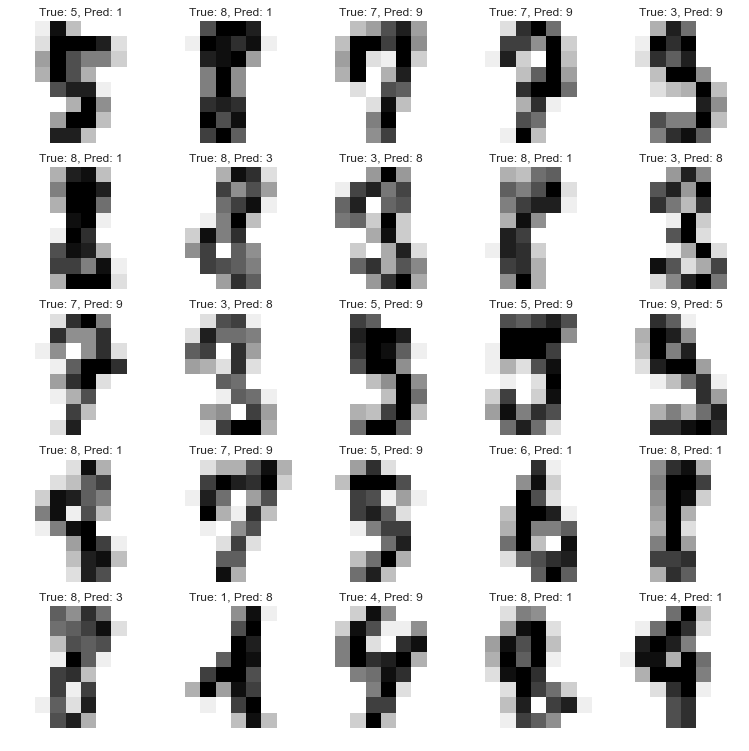

In [8]:
incorrect = y_test != pred_test

nrows = 5
ncols = 5

# Number of misclassified digits to draw
ndigits = min(nrows * ncols, np.sum(incorrect))

_, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 13))
k = 0
for i, j in product(range(nrows), range(ncols)):
    while k < len(y_test) and y_test[k] == pred_test[k]:
        k += 1
    if k >= len(y_test):
        break
    label_true = y_test[k]
    label_pred = pred_test[k]
    digit = x_test[k, :].reshape((8, 8))
    axes[i, j].imshow(digit, cmap="binary")
    axes[i, j].axis("off")
    axes[i, j].set_title("True: " + str(label_true) + ", Pred: " + str(label_pred))
    k += 1
plt.show()
plt.close()